# Homework 8

## ASTR 5900, Fall 2017, University of Oklahoma

### Gaussian Mixture Models

# Problem 1

### Part A

Load the Old Faithful data (http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat) and standardize each dimension such that they have 
## zero mean and standard deviation of 1.

Use `sklearn.mixture.GaussianMixture` to estimate the density of the data using 2 Gaussian components. Take a look at the user guide ([link](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)) and the examples at the bottom of the page.

Plot the Old Faithful data using `matplotlib.pyplot` and overlay the points with the estimated density.  It is recommended you use a function such as `astroML.plotting.tools.draw_ellipse` ([link](https://github.com/astroML/astroML/blob/master/astroML/plotting/tools.py#L149)) to represent a Gaussian, but feel free to use any method you prefer that exists in `matplotlib`, `astropy`, `astroML`, or any other of the canonical python libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from astroML.plotting.tools import draw_ellipse
import colours
import random
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
import Tkinter
import os
from PIL import ImageTk, Image
import matplotlib.animation as animation
import glob

In [2]:
filename = "old-faithful.dat"
raw = np.loadtxt(filename)
# counts, eruptions, times

In [3]:
raw.shape
mu_s = np.array([np.average(raw[:,1]),np.average(raw[:,2])])
print mu_s

norm_e = np.array([x-np.average(raw[:,1]) for x in raw[:,1]])/np.std(raw[:,1])
norm_w = np.array([x-np.average(raw[:,2]) for x in raw[:,2]])/np.std(raw[:,2])

newraw = np.vstack((norm_e,norm_w)).T

[  3.48778309  70.89705882]


In [4]:
n_clusters = 2

gmm = GaussianMixture(n_components=n_clusters,covariance_type='full')
gmm.fit(newraw)

x = np.linspace(min(norm_e),max(norm_e),1000)
y = np.linspace(min(norm_w),max(norm_w),1000)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)

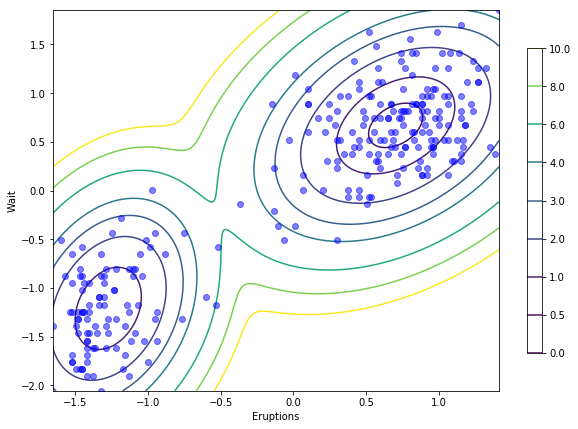

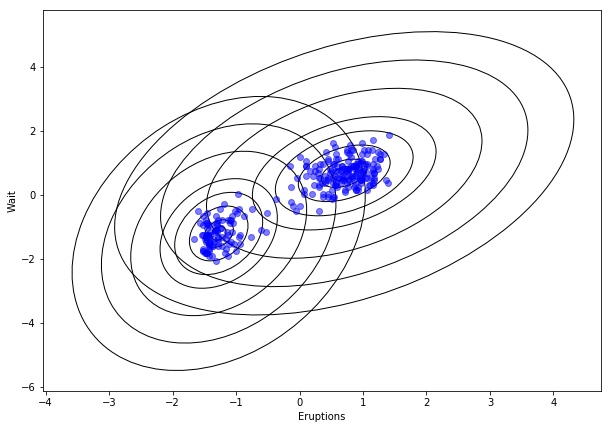

In [5]:
clevels = [0, 0.5, 1,2,3,4,6,8,10]

plt.clf()
plt.figure(figsize=[10,7])
CS = plt.contour(X, Y, Z,levels=clevels)
plt.plot(norm_e,norm_w,'bo',alpha=0.5)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.xlabel("Eruptions")
plt.ylabel("Wait")
plt.show()

plt.clf()
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
for mu, C, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(mu, C, scales=clevels, ax=ax, fc='none', ec='k')
ax.plot(norm_e,norm_w,'bo',alpha=0.5)
ax.set_xlabel("Eruptions")
ax.set_ylabel("Wait")
plt.show()

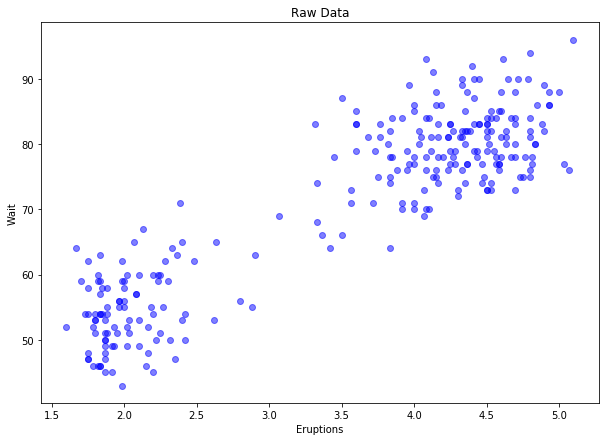

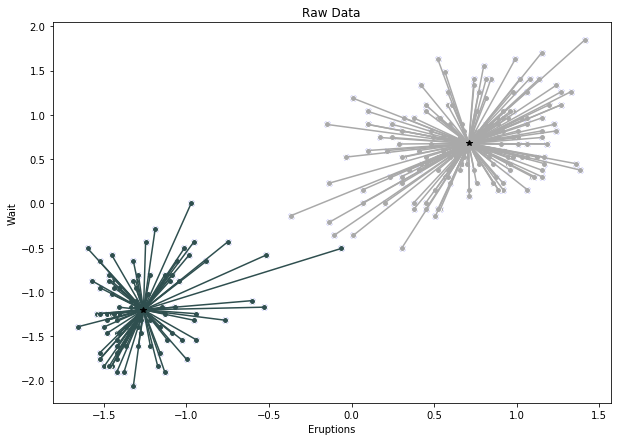

In [6]:
plt.clf()
plt.figure(figsize=[10,7])
plt.plot(raw[:,1],raw[:,2],'bo',alpha=0.5)
plt.title("Raw Data")
plt.xlabel("Eruptions")
plt.ylabel("Wait")
plt.show()

plt.clf()
plt.figure(figsize=[10,7])
plt.plot(norm_e,norm_w,'bo',alpha=0.5)
# KMeans
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
k_means.fit(newraw)

k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(newraw, k_means_cluster_centers)
for k in range(n_clusters):
    x = random.choice(range(len(colors.cnames)))
    colour = [j for i,j in enumerate(colors.cnames) if i==x][0]
    
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(newraw[my_members, 0], newraw[my_members, 1], 'w',
            markerfacecolor=colour, marker='o')
    for i in newraw[my_members,:]:
        plt.plot((i[0],cluster_center[0]),(i[1],cluster_center[1]),color=colour)
    plt.plot(cluster_center[0], cluster_center[1], '*', color="black")
plt.title("Raw Data")
plt.xlabel("Eruptions")
plt.ylabel("Wait")
plt.show()


### Part B

Using the *expectation-maximization* (EM) algorithm, build a Gaussian mixture model with 2 components from scratch for the Old Faithful data.  You are limited to default python and `numpy`.  

The EM algorithm was the subject of a 1977 paper by *Dempsey et al* (https://www.cse.iitb.ac.in/~pjyothi/cs753/EM.pdf).  Bishop describes the iterative procedure applied to GMM in Section 9.2.2.  The method is also in the lecture.  Plot each 'maximization' step in the same manner as what you did in Part A.

In [7]:
def gaussian(x,mu,sig):
    return 1./np.sqrt(2.*sig)*np.exp(-(x-mu)**2/(2.*sig**2))

def plotter(mu,C,i,clevels):
    plt.clf()
    fig = plt.figure(figsize=[10,7])
    ax = fig.add_subplot(111)
    draw_ellipse(mu, C, scales=clevels, ax=ax, fc='none', ec='k')
    ax.set_xlabel("Eruptions")
    ax.set_ylabel("Wait")
    plt.xlim(-4,4)
    plt.ylim(-4,4)
    plt.title("Iteration: ".format(i))
    plt.show()
def plot_log_likelihood(X):
    plt.clf()
    plt.figure(figsize=[10,7])
    plt.title('Log Likelihood vs Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Log Likelihood')
    plt.plot(X[:,0],X[:,1])
    plt.show()
def randparams(limits):
    limmu,limsig= np.linspace(limits[0,0],\
                              limits[0,1],1000),\
                              np.linspace(limits[1,0],\
                                          limits[1,1],1000)
    muran,sigran = random.sample(limmu,1),random.sample(limsig,1)
    return muran,sigran

def convergance(old,new,conv_param = 0.00001):
    if type(old) is list:
        old=old[0]
    if type(new) is list:
        new=new[0]
        
    if np.abs(old) != np.inf:
        return (np.abs(np.float(old)-np.float(new)) < conv_param)
    else:
        return False

# This code doesn't work(it does compile though) so no use compiling, just count as wrong. Can't figure out how to keep the means within bounds

In [8]:
def prob(Q, mu,sigma):    
    X = Q.T
    base = np.linalg.det(sigma)
    power1 = -0.5**(2.*np.pi)
    power2 = -1.0*X.shape[1]/2.
    
    # matrix multiplication
    einstein = np.einsum('ij,ij -> i',X-mu, np.dot(np.linalg.inv(sigma), (X-mu).T).T)
    
    return base**(power1**power2) * np.exp(-0.5*einstein)

def EM(X, kclusters=1, max_iterations = 10000):
    
    numpoints,dim = X.shape

    pi = np.ones((kclusters,1))
        
    mu = X[np.random.choice(numpoints,kclusters,False),:]
    
    sig = [np.eye(dim)] * kclusters
    
    llike = []
    
    assignment = np.zeros((numpoints,kclusters))
    
    while len(llike) < max_iterations:
        # E
        for k in range(kclusters):
            '''            
            print X.shape
            print mu.shape
            print len(sig)
            print pi.shape
            print assignment.shape
            '''
            assignment[:,k] = pi[k] * prob(X.T,mu[k],sig[k])
        
        temp_llike = np.sum(np.log(np.sum(assignment,axis=1)))
            
        llike.append(temp_llike)
        assignment=(assignment.T / np.sum(assignment,axis=1)).T
    
        num_points_k = np.sum(assignment,axis=0)
        
        # M
        for k in range(kclusters):
            mu[k] = 1.0/num_points_k[k] * np.sum(assignment[:,k] * X.T,axis=1).T
            X_mu = np.matrix(X-mu[k])
            sig[k] = np.array(1 / num_points_k[k] * np.dot(np.multiply(X_mu.T,  assignment[:, k]), X_mu))
            pi[k] = 1. / numpoints * num_points_k[k]
            plt.clf()
            plotter(mu[k],sig[k],len(llike),clevels)
        print("Iteration: ".format(len(llike)))
            
        if convergance(llike,temp_llike):   
            return mu,sig,pi,llike
            break
        else:
            continue

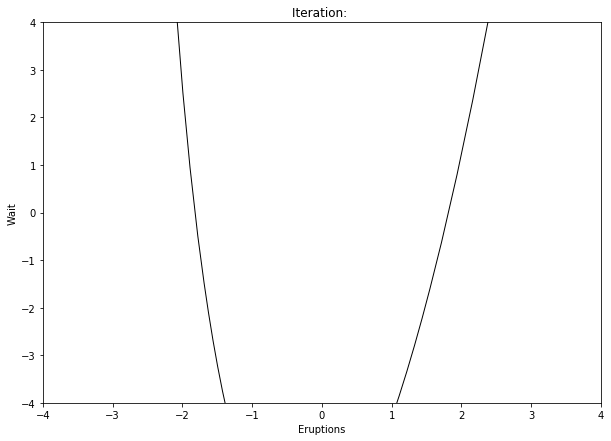

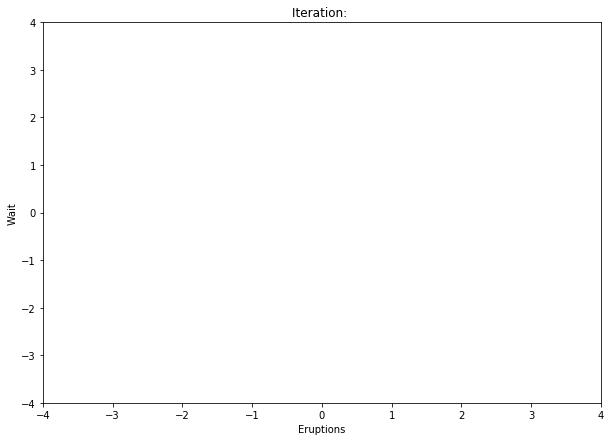

Iteration: 


In [9]:
# def EM(X, kclusters=1, max_iterations = 10000):
#  return mu,sig,pi,llike

data = raw[:,1:3]
while True:
    try:
        est_mu,est_sig,est_pi,est_llike = EM(data,2,100)
        break
    except Nonetype:
        continue
        count += 1
        if count > 10:
            print("Failing")
            break

In [10]:
print("Mu: {}".format(est_mu))
print("Sig: {}".format(est_sig))
print("Pi: {}".format(est_pi))
print("Log Like: {}".format(est_llike))

Mu: [[  2.13495135  55.15533902]
 [  4.31228993  80.49112386]]
Sig: [array([[  0.20999716,   1.50731687],
       [  1.50731687,  38.88848226]]), array([[  0.16577336,   0.60592873],
       [  0.60592873,  29.59903723]])]
Pi: [[ 0.37867645]
 [ 0.62132355]]
Log Like: [-5577.4000647236317]


# Problem 2

The data you will use for this homework problem comes from a Chandra
X-ray observatory observation of the Bullet Cluster.  The bullet
cluster is an important object in astronomy, as its morphology
compared with gravitational lensing results support the existence of
dark matter (versus, e.g., MOND).

### Part A

Load the data from `bullet.dat`.

Scatter plot the data.

Plot a 2d histogram of the data. Experiment with the binsize and plot representation until you obtain a pleasing image.  Comment on any structure you notice.

In [11]:
filename = "bullet.dat"
bulletraw = np.loadtxt(filename)
# counts, eruptions, times

In [12]:
print bulletraw.shape

(8892, 2)


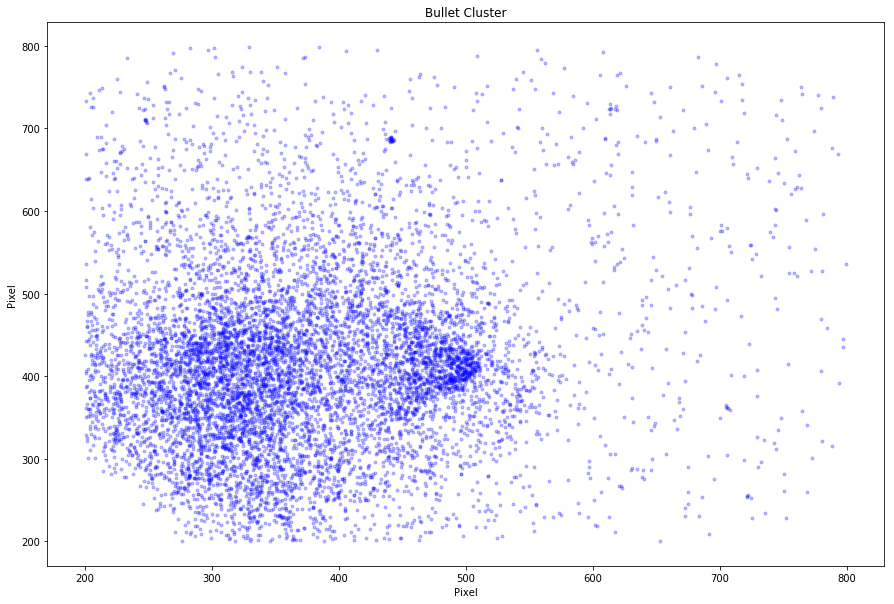

In [13]:
plt.clf()
plt.figure(figsize=[15,10])
plt.plot(bulletraw[:,0],bulletraw[:,1],'b.',alpha=0.25)
plt.title("Bullet Cluster")
plt.xlabel("Pixel")
plt.ylabel("Pixel")

plt.show()

[ 377.15598414  418.180167  ]


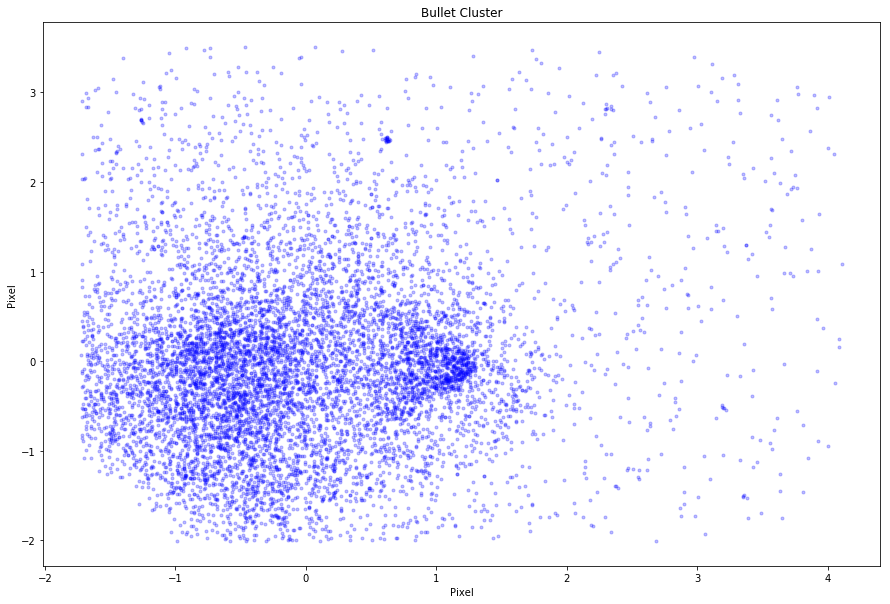

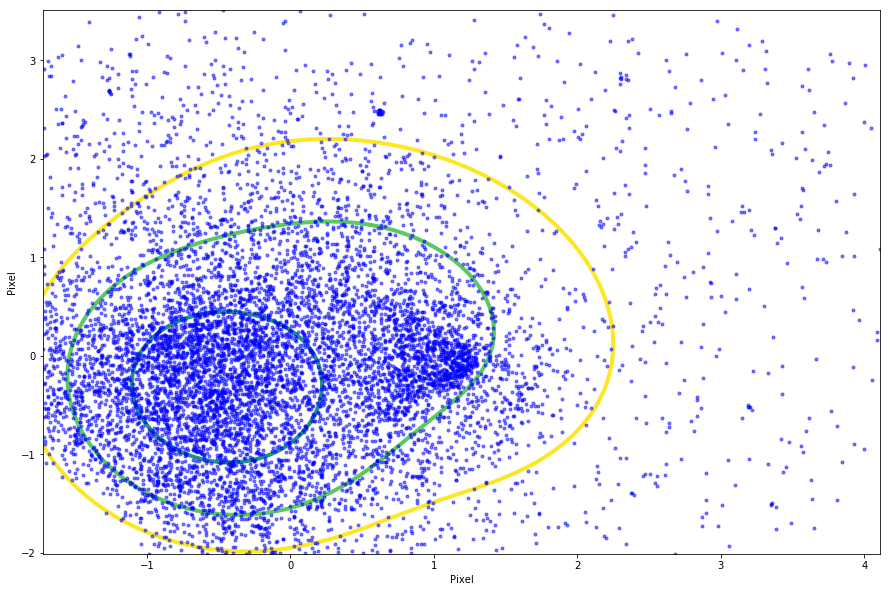

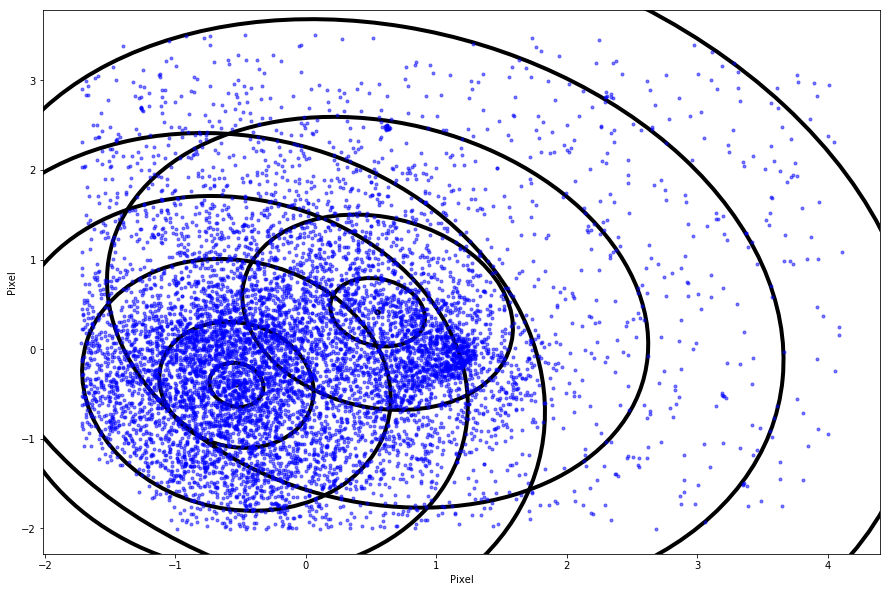

In [14]:
'''
binnum = 50

plt.clf()
plt.figure(figsize=[15,10])
counts,bining,ignore = plt.hist(bulletraw[:,0],bins=binnum)
plt.title("Bullet Cluster")
plt.xlabel("Pixel")
plt.ylabel("Counts")
plt.show()
plt.clf()
plt.figure(figsize=[15,10])
counts,bining,ignore = plt.hist(bulletraw[:,1],bins=binnum)
plt.title("Bullet Cluster")
plt.xlabel("Pixel")
plt.ylabel("Counts")
plt.show()
'''
mu_s = np.array([np.average(bulletraw[:,0]),np.average(bulletraw[:,1])])
print mu_s

norm_e = np.array([x-np.average(bulletraw[:,0]) for x in bulletraw[:,0]])/np.std(bulletraw[:,0])
norm_w = np.array([x-np.average(bulletraw[:,1]) for x in bulletraw[:,1]])/np.std(bulletraw[:,1])

newraw = np.vstack((norm_e,norm_w)).T

plt.clf()
plt.figure(figsize=[15,10])
plt.plot(newraw[:,0],newraw[:,1],'b.',alpha=0.25)
plt.title("Bullet Cluster")
plt.xlabel("Pixel")
plt.ylabel("Pixel")

plt.show()

n_clusters = 2

gmm = GaussianMixture(n_components=n_clusters,covariance_type='full')
gmm.fit(newraw)

x = np.linspace(min(norm_e),max(norm_e),1000)
y = np.linspace(min(norm_w),max(norm_w),1000)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)
clevels = [0.001,0.01, 1-0.65, 1,2,3,4]
plt.clf()
plt.figure(figsize=[15,10])
CS = plt.contour(X, Y, Z,levels=clevels,linewidths=4)
plt.plot(norm_e,norm_w,'b.',alpha=0.5)
plt.xlabel("Pixel")
plt.ylabel("Pixel")
plt.show()

plt.clf()
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)
ax.plot(norm_e,norm_w,'b.',alpha=0.5)
for mu, C, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(mu, C, scales=clevels, ax=ax, fc='none', ec='k',linewidth=4)
ax.set_xlabel("Pixel")
ax.set_ylabel("Pixel")
plt.show()

### Part B

Use `sklearn.mixture.GaussianMixture` to build a GMM on the bullet data with a range of components from 1 to 20.  Evaluate the AIC and BIC for each model.  Plot these criteria as a function of the number of components, with proper labels.  Consider how these functions are evaluated from the lecture and look up any helpful instance methods that belong to `GaussianMixture`.

Don't forget to the answer the discussion prompt below.

In [15]:
n_clusters = 20

for ncl in range(1,n_clusters+1):
    plt.clf()
    fig = plt.figure(figsize=[15,10])
    ax = fig.add_subplot(111)
    ax.set_xlabel("Pixel")
    ax.set_ylabel("Pixel")
    ax.plot(norm_e,norm_w,'b.',alpha=0.5)
    gmm = GaussianMixture(n_components=ncl,covariance_type='full')
    gmm.fit(newraw)
    AIC = gmm.aic(newraw)
    BIC = gmm.bic(newraw)
    #print AIC,BIC
    clevels = [1]
    models = []
    for mu, C, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(mu, C, scales=clevels, ax=ax, fc='none', ec='k',linewidth=4)

    plt.title("Clusters: {0}, AIC: {1:.3}, BIC: {1:.3}".format(ncl,AIC,BIC))
    if ncl < 10:
        name = 'temp_0' + str(ncl) + '.png'
    else:
        name = "temp_"+str(ncl)+".png"
    plt.draw()
    plt.savefig(name)
# converted images to video
# convert -set delay 3 -loop 0 -scale 100% *.png hw8animation.gif

/usr/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


## Discussion

Based on your results, which model best captures the structure of the data?  Why?  Do not just look at their information criteria; consider how well each model passes the 'eye test'.

It looks like the 2 cluster maybe 3 cluster fits the best. The two cluster gathers the entirety of displaced gas from the collision but the enter of the cluster is a little off. The three cluster gives good centers but gives a superfluous cluster away from the interesting features.

# Problem Z

Comment on how long this assignment took to complete.

Awhile. >10 hours but done working on it
